In [37]:
!pip install imbalanced-learn

In [17]:
!pip install joblib

In [38]:
!pip install pandas

In [39]:
!pip install plotly

In [40]:
!pip install seaborn

In [41]:
!pip install nltk

In [1]:
!pip -qqq install textstat
!pip -qqq install stylecloud

import pandas as pd
import numpy as np
import textstat
from tqdm.auto import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns
import stylecloud
from IPython.display import Image


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from string import punctuation

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **1) EDA**

In [45]:
df_train = pd.read_csv('train.csv')

In [46]:
df_test = pd.read_csv('test.csv')

In [47]:
data = pd.concat([df_train, df_test], ignore_index=True)
data

,Id,Comment,Topic
0,0x840,A few things. You might have negative- frequen...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot o...,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry
...,...,...,...
10276,0x22bf,I’m not really denying your intent. I’m a) dou...,Chemistry
10277,0x1f4a,i really empathize with your compassion for bu...,Biology
10278,0x27b7,"If you want to keep it for more than 2 weeks, ...",Chemistry
10279,0x2066,Same here. I’m in nursing school so I only hav...,Biology


In [48]:
# Удаление колонки 'Id', которая не несет никакой значимой информации
data = data.drop(columns=['Id'])

In [49]:
data.describe()

,Comment,Topic
count,10281,10281
unique,9382,3
top,[removed],Biology
freq,114,4205


In [50]:
data.isna().sum()

,0
Comment,0
Topic,0


Набор данных содержит 3 уникальных класса (физика, химия и биология). Наиболее популярным классом является "Биология".

В данных нет пропущенных значений.

Text(0.5, 1.0, 'Train')

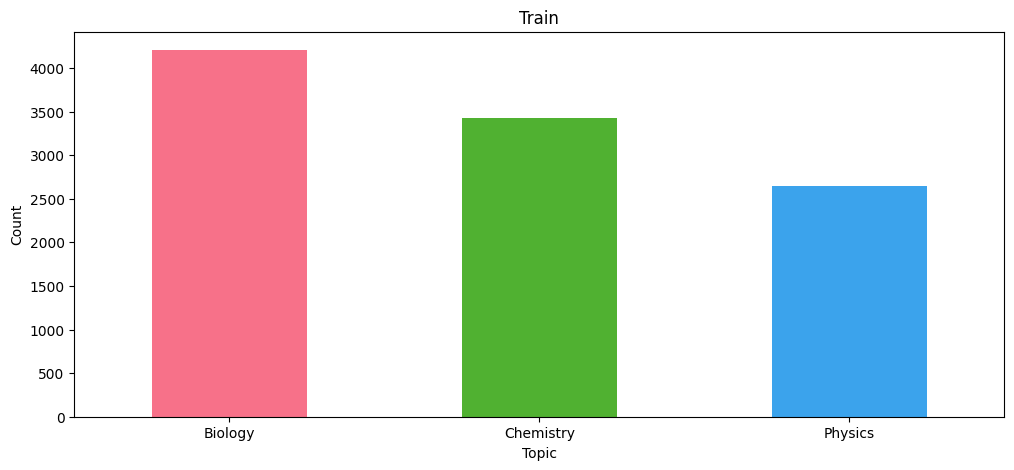

In [51]:
unique_topics = data['Topic'].unique()

# Установка цветовой палитры
palette = sns.color_palette("husl", len(unique_topics))

plt.figure(figsize=(12, 5))

# График для обучающей выборки
topic_counts_train = data['Topic'].value_counts()
topic_counts_train.plot(kind='bar', color=palette)
plt.xticks(rotation=0)
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Train')



 Выборка не является сильно несбалансированной, так как разница в количестве между классами не критична. Однако количество данных по физике заметно меньше, чем по другим предметам.

Влияние на обучение: Модель может лучше обучаться на более представленных классах, в то время как класс с меньшим количеством данных (физика) может быть хуже представлен. Это может приводить к проблемам, когда модель будет предсказывать класс "физика" реже, чем предсказывает "биология" или "химия".

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordclouds(df, topic_column='Topic', comment_column='Comment'):
    """
    Генерирует облака слов для каждой категории в указанном столбце датафрейма.
    """
    categories = df[topic_column].unique()

    for category in categories:
        comments = df[df[topic_column] == category][comment_column].values
        all_comments = ' '.join(comments)

        wordcloud = WordCloud(width=400, height=300,
                              background_color='white',
                              stopwords=None,
                              min_font_size=10).generate(all_comments)

        plt.figure(figsize=(9, 4), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Облако слов для категории: {category}')
        plt.tight_layout(pad=0)
        plt.show()


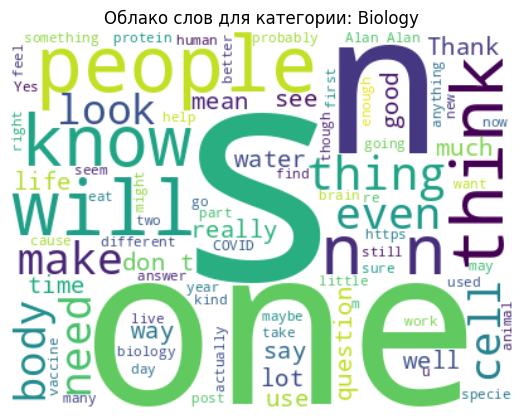

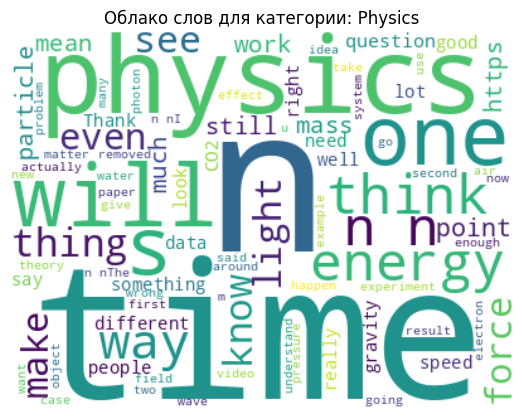

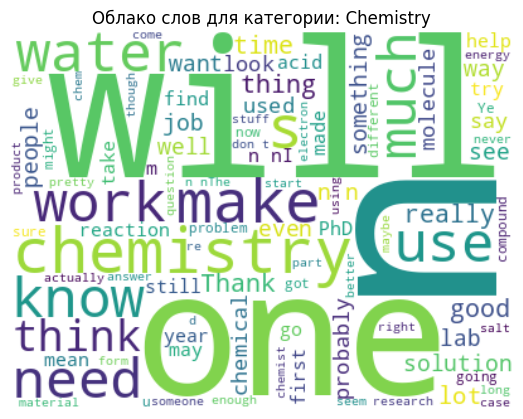

In [53]:
generate_wordclouds(data, 'Topic', 'Comment')

Для класса Биология наиболее популярными словами являются: one, will, n, s, people

Для класса Физика наиболее популярными словами являются: time, n, phisics, will, one

Для класса Химия наиболее популярными словами являются: will, make, one, chemisty, s


Поскольку в каждом классе популярны слова will, s, n, one возможно стоит их убрать и они не повлияют на результат классификации.

In [54]:
def clean_text(text):

    # Удаление специальных символов и приведение к нижнему регистру
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9s]', '', text).lower()

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    # Дополнение стоп-слов своими
    custom_stop_words =  ['n', 's', 'will, one']
    stop_words.update(custom_stop_words)
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Удаление лишних пробелов
    text = re.sub(r's+', ' ', text).strip()

    return text

data['clean_text'] = data['Comment'].apply(clean_text)

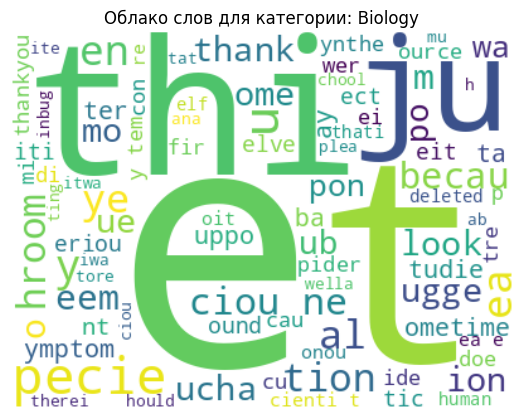

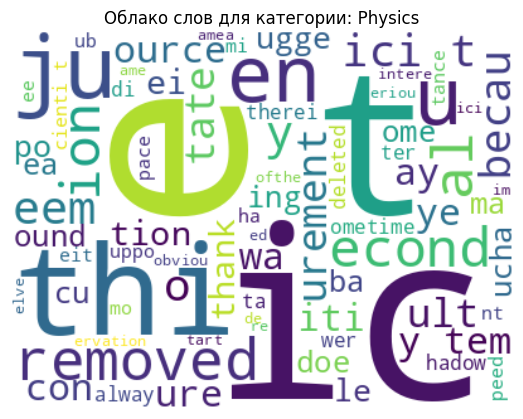

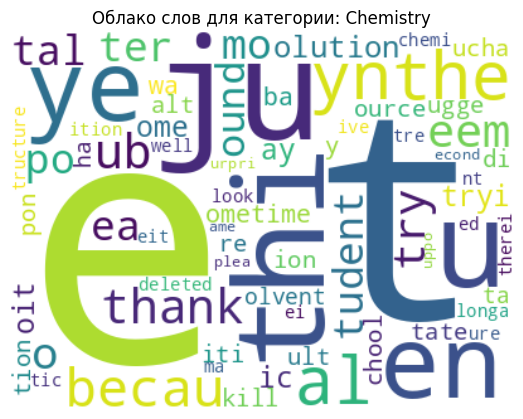

In [55]:
generate_wordclouds(data, 'Topic', 'clean_text')

In [56]:
# Создание экземпляра стеммера
stemmer = SnowballStemmer("english")

# Функция для стемминга текста
def stem_text(text):
    words = nltk.word_tokenize(text)  # Токенизация
    stems = [stemmer.stem(word) for word in words]  # Стемминг
    return ' '.join(stems)

# Применение стемминга к столбцу 'Comment'
data['stemmed_text'] = data['Comment'].apply(stem_text)

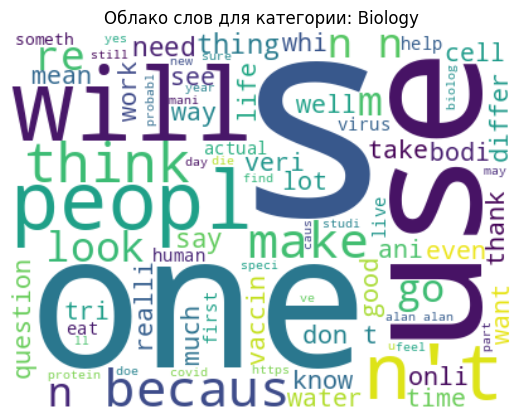

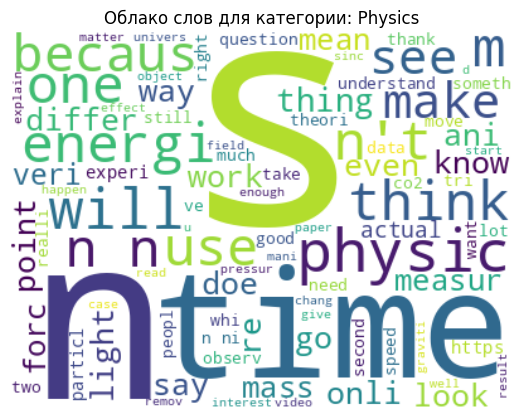

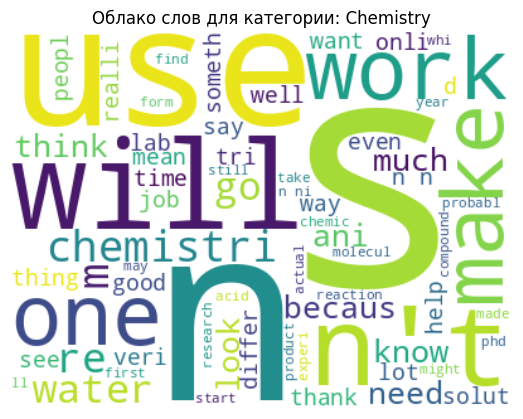

In [57]:
generate_wordclouds(data, 'Topic', 'stemmed_text')

In [58]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = word_tokenize(text)  # Токенизация
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]  # Лемматизация
    return ' '.join(lemmatized_words)

# Применяем лемматизацию и добавляем новый столбец в DataFrame
data['lemmatized_text'] = data['Comment'].apply(lemmatize_text)

In [59]:
data['lemmatized_text'] = data['Comment'].apply(lemmatize_text)

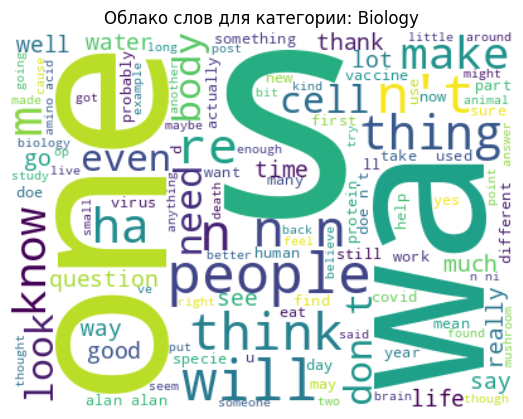

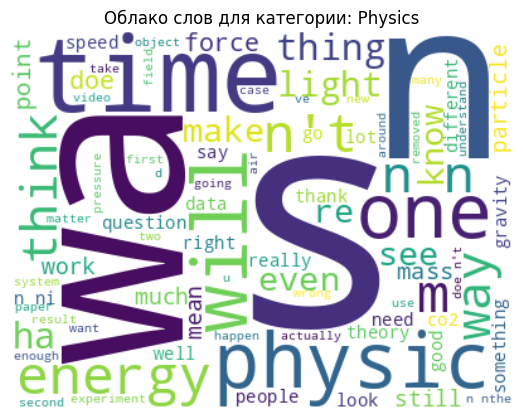

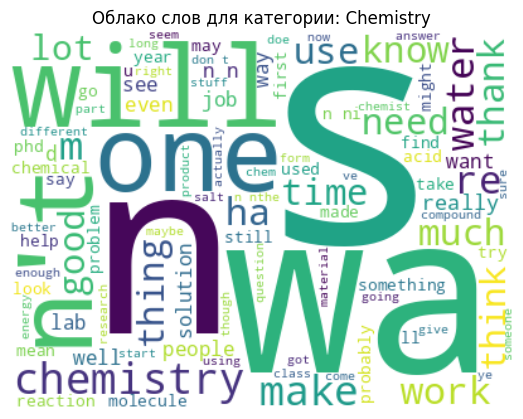

In [60]:
generate_wordclouds(data, 'Topic', 'lemmatized_text')

In [61]:
data['stemmed_lemmatized_text'] = data['stemmed_text'].apply(lemmatize_text)

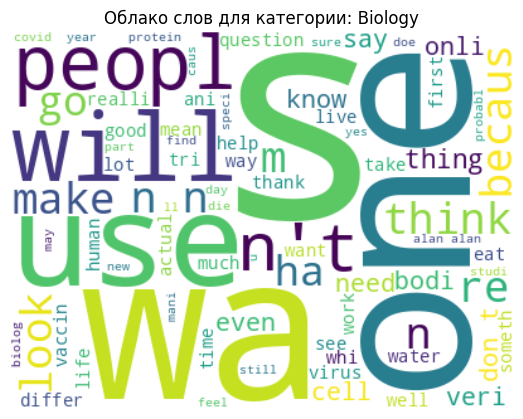

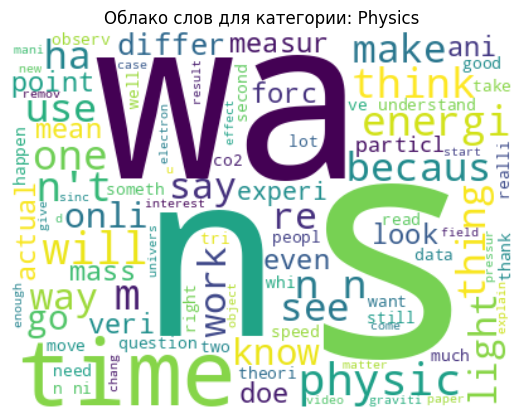

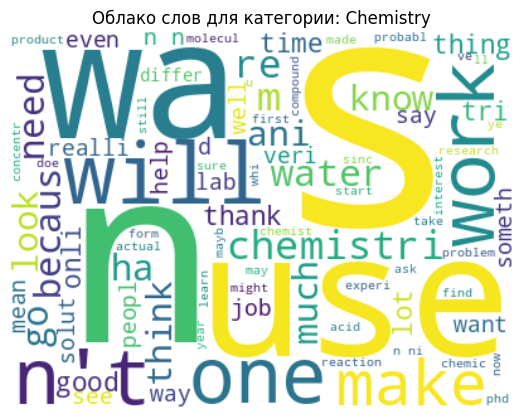

In [62]:
generate_wordclouds(data, 'Topic', 'stemmed_lemmatized_text')

После очистки нельзя по популярным словам однозначно сказать какой класс к кому относится, хотя до очистки было легко определить класс. Тогда как после stemmed и lemmatized все еще можно определить класс. В связи с этим предположение, что очистка ухудшит результаты.

In [63]:
# Преобразуем категориальный признак в числовой
data['Topic'] = data['Topic'].map({'Biology': 0, 'Chemistry': 1, 'Physics': 2})

In [ ]:
data.isna().sum()

После очитки текста появились пропуски в данных. Удалим строки с пропусками.

In [65]:
data = data.dropna()

In [66]:
data.isna().sum()

,0
Comment,0
Topic,0
clean_text,0
stemmed_text,0
lemmatized_text,0
stemmed_lemmatized_text,0


Text(0.5, 1.0, 'Train')

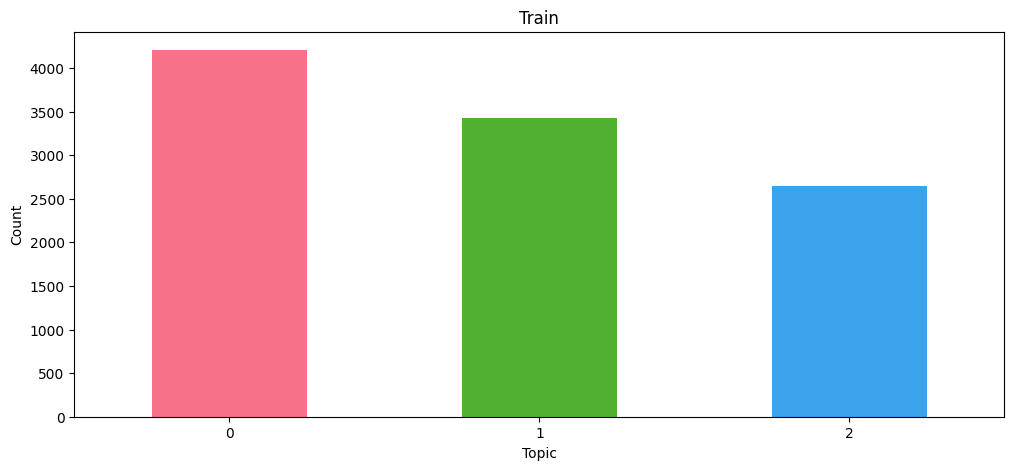

In [72]:
unique_topics = data['Topic'].unique()

# Установка цветовой палитры
palette = sns.color_palette("husl", len(unique_topics))

plt.figure(figsize=(12, 5))

# График для обучающей выборки
topic_counts_train = data['Topic'].value_counts()
topic_counts_train.plot(kind='bar', color=palette)
plt.xticks(rotation=0)
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Train')

Распределение данных не изменилось

In [67]:
data.to_csv('data.csv', index=False)

### **2) embeddings**

In [42]:
data = pd.read_csv('data.csv')

In [43]:
text_types = [
    'Comment',
    'clean_text',
    'stemmed_text',
    'lemmatized_text',
    'stemmed_lemmatized_text']

In [44]:
from sklearn.model_selection import train_test_split

split_data_results = {}

for text_type in tqdm(text_types):

    vectorizer = TfidfVectorizer(ngram_range=(1,1), lowercase=True, min_df=1, max_df=0.5, stop_words= 'english')
    encoded_data = vectorizer.fit_transform(data[text_type]).toarray()

    data_X = pd.DataFrame(encoded_data, columns=vectorizer.get_feature_names_out())
    data_y = pd.get_dummies(data['Topic'])

    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.5, random_state=42, stratify = data_y, shuffle=True)

    split_data_results[text_type] = X_train, X_test, y_train, y_test

100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


### **3) ML-algorithms**

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [47]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from tqdm import tqdm

# Определим переменные для наилучших параметров
best_params = None

# Сначала определим лучшие параметры на первом текстовом типе
for text_type in tqdm(text_types):
    X_train, X_test, y_train, y_test = split_data_results[text_type]

    model = RandomForestClassifier(class_weight='balanced')
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Сохраним наилучшие параметры только с первого текстового типа
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Сохраняем лучшую модель
    model_filename = f"best_model_{text_type}.joblib"
    joblib.dump(best_model, model_filename)
    print(f"Модель сохранена в {model_filename}")
    
    break  # Прерываем цикл после первой итерации

  0%|          | 0/5 [00:00<?, ?it/s]

Модель сохранена в best_model_Comment.joblib


  0%|          | 0/5 [40:50<?, ?it/s]


In [48]:
# Теперь применяем найденные лучшие параметры ко всем текстовым типам
results ={}
for text_type in tqdm(text_types):
    
    X_train, X_test, y_train, y_test = split_data_results[text_type]

    # Создаем модель с оптимальными параметрами
    model = joblib.load('best_model_Comment.joblib')

    # Обучаем модель
    tqdm(model.fit(X_train, y_train))
    
    # Делаем предсказания
    y_pred = model.predict(X_test)
    
    results[text_type] = {'y_pred': y_pred }
    
    # Вывод отчета о классификации
    print(text_type)
    print(classification_report(y_test, y_pred))


  0%|          | 0/50 [00:00<?, ?it/s]


Comment
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      2102
           1       0.72      0.50      0.59      1701
           2       0.83      0.50      0.63      1321

   micro avg       0.79      0.52      0.63      5124
   macro avg       0.79      0.52      0.63      5124
weighted avg       0.79      0.52      0.63      5124
 samples avg       0.52      0.52      0.52      5124



  0%|          | 0/50 [00:00<?, ?it/s]


clean_text
              precision    recall  f1-score   support

           0       0.79      0.29      0.42      2102
           1       0.42      0.74      0.54      1701
           2       0.76      0.23      0.35      1321

   micro avg       0.52      0.42      0.47      5124
   macro avg       0.66      0.42      0.44      5124
weighted avg       0.66      0.42      0.44      5124
 samples avg       0.42      0.42      0.42      5124



  0%|          | 0/50 [00:00<?, ?it/s]


stemmed_text
              precision    recall  f1-score   support

           0       0.82      0.58      0.68      2102
           1       0.75      0.49      0.59      1701
           2       0.83      0.52      0.64      1321

   micro avg       0.80      0.53      0.64      5124
   macro avg       0.80      0.53      0.64      5124
weighted avg       0.80      0.53      0.64      5124
 samples avg       0.53      0.53      0.53      5124



  0%|          | 0/50 [00:00<?, ?it/s]


lemmatized_text
              precision    recall  f1-score   support

           0       0.83      0.57      0.68      2102
           1       0.72      0.51      0.60      1701
           2       0.83      0.51      0.63      1321

   micro avg       0.79      0.54      0.64      5124
   macro avg       0.79      0.53      0.64      5124
weighted avg       0.79      0.54      0.64      5124
 samples avg       0.54      0.54      0.54      5124



  0%|          | 0/50 [00:00<?, ?it/s]


stemmed_lemmatized_text
              precision    recall  f1-score   support

           0       0.82      0.58      0.68      2102
           1       0.75      0.49      0.59      1701
           2       0.82      0.51      0.63      1321

   micro avg       0.80      0.53      0.64      5124
   macro avg       0.80      0.53      0.63      5124
weighted avg       0.80      0.53      0.64      5124
 samples avg       0.53      0.53      0.53      5124



100%|██████████| 5/5 [07:32<00:00, 90.44s/it]


Лучший результат показал на данных с lemmatized, практически такие же результаты для обработки stemmed и одновременно stemmed lemmatized, худший результат как и предполагалось на данных с очисткой. Очистка текста не только не улучшила результат, но и ухудшила его, что было предсказуемо, видя какое облоко слов построенно на этих данных, поэтому не было эксперементов в которых очистка с чем-нибудь сочиталась.

Поскольку изначальные данные были немного несбалансированы, при создании модели использовалась настройка для балансировки, котороая позволила предсказывать классы "Физика" и "Химия" практически также как и класс "Биология".

### **4) Нейронные сети**